In [1]:
!pip install pyspark findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b7ca25f273628e79e35111358be0d9d82b370c8b7b894f2fab962a4a8270c6a5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mnist_mini = "/content/drive/MyDrive/Colab Notebooks/MMDS/final/mnist_mini.csv"

In [4]:
ratings2k = "/content/drive/MyDrive/Colab Notebooks/MMDS/final/ratings2k.csv"

In [5]:
stockHVN2022 = "/content/drive/MyDrive/Colab Notebooks/MMDS/final/stockHVN2022.csv"

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors as VectorsML

from pyspark.sql import Row, DataFrame
from pyspark.sql.functions import udf, col, sum, count, monotonically_increasing_id, when, to_date, month, \
                                    lag, col, month, array

from pyspark.sql.types import IntegerType, FloatType, ArrayType, DoubleType
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import DenseMatrix, Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS

import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [7]:
spark = SparkSession.builder.appName("Final_Project").getOrCreate()

# `Task 1: Clustering`

In [8]:
class Clustering:
    def __init__(self, data_path:str ,k:int, weighted_rows:list):
        self.data = None
        self.sum_count_df = None
        self.data_path = data_path
        self.k = k
        self.weighted_rows = weighted_rows
        self.transformed_data = None

    def load_data(self):
        self.data = spark.read.csv(self.data_path, header=False, inferSchema=True)

    def preprocess_data(self):
        assembler = VectorAssembler(inputCols=self.data.columns[1:], outputCol="features")
        self.data = assembler.transform(self.data).select("_c0", "features")

        self.data = self.data.withColumn("row_index", monotonically_increasing_id())
        self.data = self.data.withColumn("weight", when(self.data["row_index"].isin(self.weighted_rows), 100).otherwise(1)) \
                            .drop("row_index")

    def clustering(self):
        kmeans = KMeans(featuresCol="features", k=self.k, weightCol="weight", seed=42)
        model = kmeans.fit(self.data)
        transformed_data = model.transform(self.data)
        self.transformed_data = transformed_data

        l_clusters = model.clusterCenters()
        df_centers = spark.createDataFrame([(int(i), VectorsML.dense(l_clusters[i]))
                    for i in range(len(l_clusters))], ["prediction", "center"])

        transformed_data = transformed_data.join(df_centers, on='prediction', how='left')

        get_dist = udf(lambda features, center: float(math.sqrt(VectorsML.squared_distance(features, center))), FloatType())
        transformed_data = transformed_data.withColumn('dist', get_dist(col('features'), col('center')))

        self.sum_count_df = transformed_data.groupBy("prediction") \
            .agg(sum("dist").alias("sum_distance"),
                 count("*").alias("count")) \
            .withColumn('average_dist', col('sum_distance') / col('count')) \

    def plot_average_distance(self):
        result_list = self.sum_count_df.select("prediction", "average_dist").collect()

        prediction = [row.prediction for row in result_list]
        average_dist = [row.average_dist for row in result_list]

        fig, ax = plt.subplots()
        ax.bar(prediction, average_dist)
        ax.set_xlabel('k')
        ax.set_ylabel('Average Distance')
        ax.set_title('Average Distance by Prediction')
        plt.xticks(prediction)
        plt.show()

    def run(self):
        self.load_data()
        self.preprocess_data()
        self.clustering()
        self.plot_average_distance()

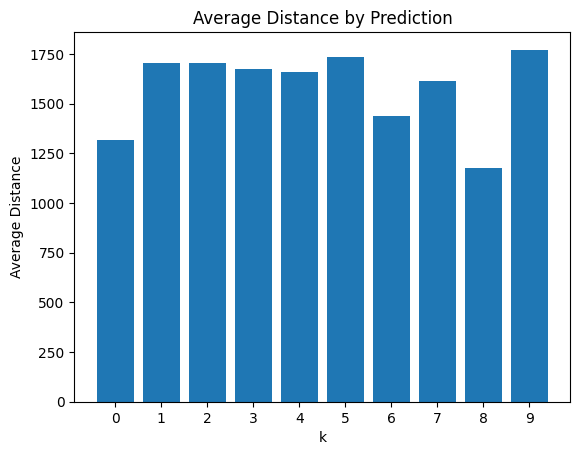

In [9]:
if __name__ == "__main__":
    weighted_rows = [0, 1, 2, 3, 4, 7, 8, 11, 18, 61]
    clustering = Clustering(data_path = mnist_mini, k = 10, weighted_rows = weighted_rows)
    clustering.run()

# `Task 2: Dimensionality Deduction with SVD`

In [10]:
class SVD:
    def __init__(self, data_path:str, clustering_result:DataFrame):
        self.data = None
        self.data_path = data_path
        self.processed_data = None
        self.clustering_result = clustering_result

    def load_data(self):
        self.data = spark.read.csv(self.data_path, header=False, inferSchema=True)

    def preprocess_data(self):
        assembler = VectorAssembler(inputCols=self.data.columns[1:], outputCol="features")
        self.data = assembler.transform(self.data) \
                        .select("_c0", "features")

    def svd(self):
        ml_vectors = self.data.select("features").rdd.map(lambda row: Vectors.dense(row.features.toArray()))
        row=RowMatrix(ml_vectors)
        svd = row.computeSVD(3, True)
        u = svd.U
        s = DenseMatrix(len(svd.s), len(svd.s), np.diag(svd.s).ravel("F"))

        def row_to_dict(row):
            return Row(features=Vectors.dense(row.toArray()))

        row_matrix_rows = u.multiply(s).rows.map(row_to_dict)
        df = spark.createDataFrame(row_matrix_rows)

        vector_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
        df = df.withColumn("features_array", vector_to_array(df["features"]))
        df = df.select([df["features_array"][i].alias(f"_c{i+1}") for i in range(3)])

        data = self.clustering_result.withColumn("unique_id", monotonically_increasing_id())
        df = df.withColumn("unique_id", monotonically_increasing_id())
        merged_df = data[['_c0','unique_id', "prediction"]].join(df, "unique_id").drop("unique_id")

        self.processed_data = merged_df.sample(fraction=0.01).limit(100)

    def plot_3d(self):
        color = ["red", "blue", "orange", "green", "purple", "brown", "pink", "yellow", "black", "cyan"]
        marker = ["v", "*", ".", ",", "X", "P", "s", "D", "^", "v"]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for i in range(0, 10):
            data = self.processed_data.filter(self.processed_data.prediction == i)
            x = data.select('_c1').rdd.map(lambda row: row['_c1']).collect()
            y = data.select('_c2').rdd.map(lambda row: row['_c2']).collect()
            z = data.select('_c3').rdd.map(lambda row: row['_c3']).collect()
            ax.scatter(x, y, z, c=color[i], marker=marker[i])

        ax.set_title('3D K-Means Clustering with k=10 (100 Random Datapoint)')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
        plt.show()

    def run(self):
        self.load_data()
        self.preprocess_data()
        self.svd()
        self.plot_3d()

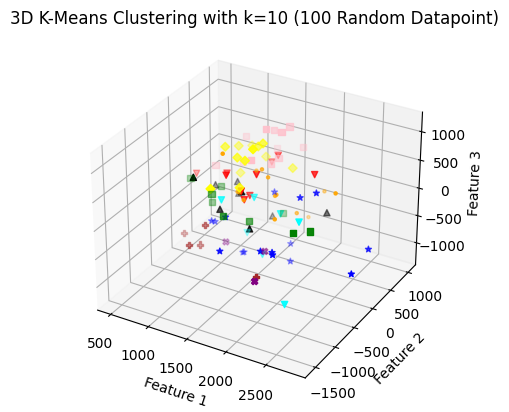

In [11]:
if __name__ == "__main__":
    svd = SVD(data_path = mnist_mini, clustering_result = clustering.transformed_data)
    svd.run()

# `Task 3: Recommendation with Collaborative Filtering`

In [12]:
class CollaborativeFiltering:
    def __init__(self, data_path: str = "ratings2k.csv", num_user_blocks_range:array = np.arange(10, 21)):
        self.data = None
        self.train_data = None
        self.test_data = None
        self.als_model = None
        self.data_path = data_path
        self.num_user_blocks_range =  num_user_blocks_range

    def load_data(self):
        self.data = spark.read.csv(self.data_path, header=True, inferSchema=True)

    def split_data(self):
        self.train_data, self.test_data = self.data.randomSplit([0.7, 0.3], seed=42)

    def train_model(self, rank=10, max_iter=20, reg_param=0.01):
        als = ALS(rank=rank, maxIter=max_iter, regParam=reg_param, userCol="user", itemCol="item", ratingCol="rating",
                  coldStartStrategy="drop", nonnegative=True)

        self.als_model = als.fit(self.train_data)

    def evaluate_model(self):
        predictions = self.als_model.transform(self.test_data)
        evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
        mse = evaluator.evaluate(predictions)
        return mse

    def visualize_results(self):
        mse_values = []
        ranks = np.arange(10, 21)
        for rank in ranks:
            self.train_model(rank = rank)
            mse = self.evaluate_model()
            mse_values.append(mse)

        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(10, 21), mse_values)
        plt.xlabel("The number of similar User")
        plt.ylabel("MeanSquare Error (MSE)")
        plt.title("MSE vs Number of similar users")
        plt.xticks(np.arange(10, 21))
        plt.show()

    def run(self):
        self.load_data()
        self.split_data()
        self.visualize_results()

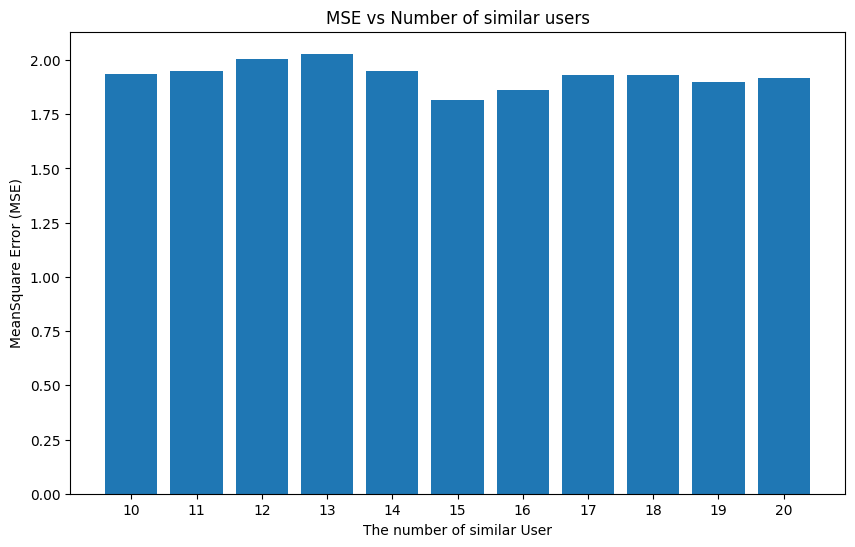

In [13]:
if __name__ == "__main__":
    collaborativeFiltering = CollaborativeFiltering(data_path = ratings2k)
    collaborativeFiltering.run()

# `Task 4: Stock price regression`

In [14]:
class StockPriceRegression:
    def __init__(self, k_prev_dates:int = 5, data_path:str = "stockHVN2022.csv"):
        self.k_prev_dates = k_prev_dates
        self.data = None
        self.data_path = data_path
        self.train_data, self.test_data  = None, None
        self.model = None
        self.train_mse, self.test_mse  = None, None

    def load_data(self):
        self.data = spark.read.csv(self.data_path, header=True, inferSchema=True)

    def preprocess_data(self):
        self.data = self.data.withColumn("Ngay", to_date(self.data.Ngay, "dd/MM/yyyy")) \
                    .orderBy('Ngay')\
                    .withColumn('fluctuation', (col('HVN') - lag('HVN', 1).over(Window.orderBy('Ngay'))) / lag('HVN', 1).over(Window.orderBy('Ngay')))\
                    .na.fill(0.0, subset=['fluctuation'])

        for i in range(1, self.k_prev_dates + 1):
            self.data = self.data.withColumn(f'prev_range_{i}', lag('fluctuation', i).over(Window.partitionBy().orderBy('Ngay')))
        self.data = self.data.dropna()

        train_data = self.data.filter(month('Ngay') <= 6) \
                        .drop("Ngay", "HVN")
        test_data = self.data.filter(month('Ngay') > 6) \
                        .drop("Ngay", "HVN")

        assembler = VectorAssembler(inputCols=list(train_data.columns[::-1][:-1]), outputCol='features')
        self.train_data = assembler.transform(train_data)
        self.test_data = assembler.transform(test_data)

    def train_model(self):
        lr = LinearRegression(featuresCol='features', labelCol='fluctuation')
        self.model = lr.fit(self.train_data)

    def evaluate_model(self):
        evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='fluctuation', metricName='mse')

        self.train_mse = evaluator.evaluate(self.model.transform(self.train_data))
        self.test_mse = evaluator.evaluate(self.model.transform(self.test_data))

    def plot_results(self):
        plt.figure(figsize=(8, 6))
        plt.bar(['Training', 'Test'], [self.train_mse, self.test_mse], color=['blue', 'green'])
        plt.xlabel('Dataset')
        plt.ylabel('Mean Squared Error')
        plt.title('Linear Regression Model Performance')
        for i, v in enumerate([self.train_mse, self.test_mse]):
            plt.text(i, v, str(v), ha='center', va='bottom')
        plt.show()

    def run(self):
        self.load_data()
        self.preprocess_data()
        self.train_model()
        self.evaluate_model()
        self.plot_results()

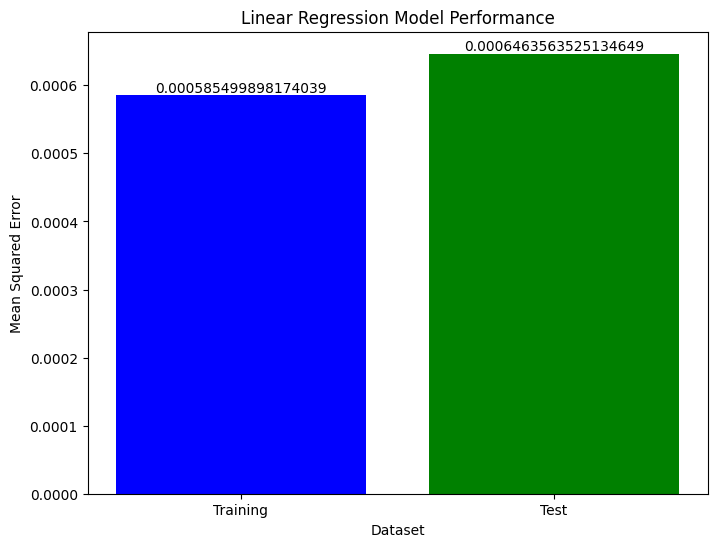

In [15]:
if __name__ == "__main__":
    stockPriceRegression = StockPriceRegression(data_path = stockHVN2022)
    stockPriceRegression.run()

# `Task 5: Multi-class classification`

In [16]:
class MultiClassClassification:
    def __init__(self, data_path:str):
        self.data = None
        self.classification = ["MLP", "RandomForest", "LinearSVC"]
        self.train_accuracies = []
        self.test_accuracies = []
        self.data_path = data_path

    def load_data(self):
        self.data = spark.read.csv(self.data_path, header=False, inferSchema=True)

    def preprocess_data(self):
        assembler = VectorAssembler(inputCols=self.data.columns[1:], outputCol="features")
        self.data = assembler.transform(self.data) \
                        .select("_c0", "features") \
                        .withColumnRenamed("_c0", "label")

    def run_classification(self):
        (train_data, test_data) = self.data.randomSplit([0.7, 0.3], seed=42)

        for classifier_name in self.classification:
            if classifier_name == "MLP":
                classifier = MultilayerPerceptronClassifier(maxIter=100, layers=[784, 128, 64, 10], blockSize=128, seed=42)
            elif classifier_name == "RandomForest":
                classifier = RandomForestClassifier(numTrees=100, maxDepth=10, seed=42)
            else:
                classifier = OneVsRest(classifier=LinearSVC(maxIter=100, regParam=0.1))

            model = classifier.fit(train_data)

            evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
            train_accuracy = evaluator.evaluate(model.transform(train_data))
            test_accuracy = evaluator.evaluate(model.transform(test_data))

            self.train_accuracies.append(train_accuracy)
            self.test_accuracies.append(test_accuracy)

    def plot_accuracies(self):
        x = np.arange(len(self.classification))
        fig, ax = plt.subplots()
        bar_width = 0.35

        rects1 = ax.bar(x - bar_width / 2, self.train_accuracies, bar_width, label='Train')
        rects2 = ax.bar(x + bar_width / 2, self.test_accuracies, bar_width, label='Test')

        ax.set_xlabel('Classifiers')
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(self.classification)
        ax.legend()
        plt.show()

    def run(self):
        self.load_data()
        self.preprocess_data()
        self.run_classification()
        self.plot_accuracies()

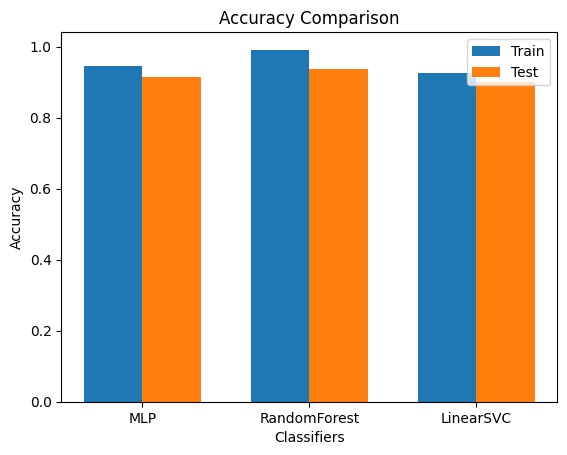

In [17]:
if __name__ == "__main__":
    multiClassClassification = MultiClassClassification(data_path = mnist_mini)
    multiClassClassification.run()

In [18]:
spark.stop()